# Práctica 24/25 - Generative AI Authorship Verification

## Índice

1. Integrantes del equipo

2. Librerías -> Revisarlo

3. Procesamiento de los datos  
<div style="margin-left:40px;">
    3.1. Carga de datos<br>
    3.2. Exploración y visualización de los datos<br>
    3.3. Preprocesamiento de los datos<br>
    3.4. Dataset & DataCollator inicial<br>
</div>

4. Experimentos  
<div style="margin-left:40px;">
    4.1. Estudio del estado del arte -> Revisarlo<br>
    4.2. Baseline: Descripción y primeros resultados -> Documentarlo<br>
    4.3. Fine-Tuning -> Depende de nuestras ganas<br>
    <div style="margin-left:20px;">
        4.3.1. BERT Base-> Documentarlo<br>
        4.3.2. BERT Large-> Documentarlo<br>
        4.3.3. T5 Small-> Documentarlo<br>
        4.3.4. Siames-> Documentarlo<br>
        <div style="margin-left:20px;">
        4.3.4.1 BERT Base-> Documentarlo<br>
        4.3.4.2 BERT Large-> Documentarlo<br>
        </div>
    </div>
    4.4 Propuestas Clasicas -> Documentarlo<br>
    <div style="margin-left:20px;">
        4.4.1 Naive Bayes con NLTK -> Documentarlo
        </div>
    </div>
</div>

5. Resultados  
<div style="margin-left:40px;">
    5.1. Métricas utilizadas<br>
    5.2. Comparativa entre nuestros modelos<br>
    5.3. Comparativa de resultados con los modelos base y otras propuestas publicadas<br>
</div>

6. Conclusiones

7. Trabajo Futuro  

## 1. Integrantes del equipo
* Alejandro Cortijo Benito
* Alejandro García Mota

## 2. Librerías

Estás son todas las librerías utilizadas para el desarrollo de la práctica, están organizadas en base a su utilidad a través de los comentarios.

In [78]:
# Sistema
import os
from glob import glob
import logging

# Eliminar los warnings que ensucian los outputs 
logging.disable(logging.WARNING)

# Procesamiento de los datos 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

# Experimentos
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import string

import torch
import transformers
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
import torch.nn.functional as F


# Resultados
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, brier_score_loss

In [31]:
# Configuración de CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 3. Procesamiento de los datos

Una vez leido y contempladas las diferentes propuestas de la competición PAN, decidimos que una de las más interesantes era la clasificación por pares de textos escritos por IA y humanos (Generative AI Authorship Verification 2024). Una vez tenemos descargado el dataset empezamos a dar los primeros pasos para resolver la práctica.

Inicialmente nos paramos a pensar en la estructura y cantidad de los datos.

### Carga de datos

In [32]:
df_human = pd.read_json('data/human.jsonl', lines=True)
df_human

,id,text
0,articles-cleaned-truncated/news-2021-01-01-202...,Inaugural Address by President Joseph R. Biden...
1,articles-cleaned-truncated/news-2021-01-01-202...,Fact check: Biden inauguration impacted by pan...
2,articles-cleaned-truncated/news-2021-01-01-202...,Highlights from Joe Biden's 2021 inauguration\...
3,articles-cleaned-truncated/news-2021-01-01-202...,"Biden takes the helm, appeals for unity to tak..."
4,articles-cleaned-truncated/news-2021-01-01-202...,'The Hill We Climb': Read Amanda Gorman's inau...
...,...,...
1082,articles-cleaned-truncated/news-2021-01-01-202...,How amateur detectives on social media helped ...
1083,articles-cleaned-truncated/news-2021-01-01-202...,Authorities searching for missing 22-year-old ...
1084,articles-cleaned-truncated/news-2021-01-01-202...,Univ. of Wisconsin Oshkosh student helping Gab...
1085,articles-cleaned-truncated/news-2021-01-01-202...,Did the Internet Actually Help Find Gabby Peti...


In [33]:
machines_files = glob('data/machine/*.jsonl')
df_human_temp = df_human.reset_index(drop=True)
df_human_temp['label'] = 0

df_machine = pd.read_json(machines_files[0], lines=True)
for file in machines_files[1:]:
    df_current = pd.read_json(file, lines=True)
    df_machine = pd.concat([df_machine, df_current])

df_machine

,id,text
0,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Inaugural Address: President Joseph R. Biden J...
1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Setting the Record Straight: Fact-Checking the...
2,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes the Oath of Office as 46th Pre...
3,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes Oath as 46th President of Unit...
4,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Amanda Gorman's Inspiring Poem Celebrates Hope...
...,...,...
1082,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,'The Disappearance of Gabby Petito' – A Compre...
1083,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"Utah State Police Search for Gabby Petito, Tra..."
1084,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,McKenna's Lost Friend: Debunking the Evidence ...
1085,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"""Gunshots Found in Florida Nature Preserve: A ..."


In [34]:
df_machine['id'][:5], df_human['id'][:5]

(0    alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
 1    alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
 2    alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
 3    alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
 4    alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
 Name: id, dtype: object,
 0    articles-cleaned-truncated/news-2021-01-01-202...
 1    articles-cleaned-truncated/news-2021-01-01-202...
 2    articles-cleaned-truncated/news-2021-01-01-202...
 3    articles-cleaned-truncated/news-2021-01-01-202...
 4    articles-cleaned-truncated/news-2021-01-01-202...
 Name: id, dtype: object)

La columna `id` nos puede ser de gran utilidad para juntar ambos conjuntos de datos ya que comparten varios rasgos en común, no solo a nivel de `types` sino también de contenido ya que cada muestra viene acompañada de una `fecha` y  una especie de `referencia` que podemos usar como `key` para filtrar.

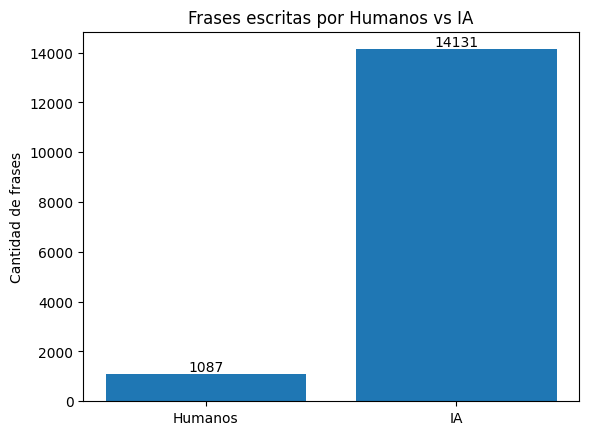

In [35]:
x = [0, 1]
y = [len(df_human), len(df_machine)]
labels = ['Humanos', 'IA']

plt.bar(x, y)

plt.xticks(x, labels)
plt.ylabel('Cantidad de frases')
plt.title('Frases escritas por Humanos vs IA')

for i, val in enumerate(y):
    plt.text(x[i], val, str(val), ha='center', va='bottom')

plt.show()

Nos dimos cuenta de que la cantidad de muestras generadas por IA era significativamente superior a las redactadas por humanos. Esto se debe a que las $1087$ frases escritas por humanos fueron reescritas por $13$ modelos de lenguaje diferentes. Este hecho nos hizo darnos que cuenta de que debíamos tener mucho cuidado a la hora de implementar el Dataset y de entrenar a los modelos, para no sufrir un posible overfitting.

### Exploración y visualización de los datos

Lo primero que tenemos que comprobar es si la calidad de los datos es optima para el caso de estudio, en este caso lo primero que miramos fue si existia alguna inconsistencia en los mismo. Para ello, comprobamos si existe alguna columna con campos de `text` vacios:

In [36]:
empty_rows_humans = df_human[(df_human['text'].isna()) | (df_human['text'] == '')]
empty_rows_machine = df_machine[(df_machine['text'].isna()) | (df_machine['text'] == '')]

len(empty_rows_humans), len(empty_rows_machine)

print("Número de muestras en df_human: ", len(df_human))
print("Número de muestras en df_machine: ", len(df_machine))

print("Número de muestras sin texto en df_human: ", len(empty_rows_humans))
print("Número de muestras sin texto en df_machine: ", len(empty_rows_machine))

Número de muestras en df_human:  1087
Número de muestras en df_machine:  14131
Número de muestras sin texto en df_human:  0
Número de muestras sin texto en df_machine:  28


Parece que hay `28` campos de texto vacios en el dataframe de machines, ya que no es un número significativo procemos a borrar dichas muestras:

In [37]:
df_human = df_human[~df_human['text'].isna() & (df_human['text'] != '')]
df_machine = df_machine[~df_machine['text'].isna() & (df_machine['text'] != '')]

len(df_human), len(df_machine) # 14131 - 28 = 14103

(1087, 14103)

Decidimos seguir profundizando en los datos, con el objetivo de detectar algún patrón que pudiera ser de utilidad para el desarrollo de la práctica. Además de seguir familiarizandonos con el caso de estudio a través de los datos. 

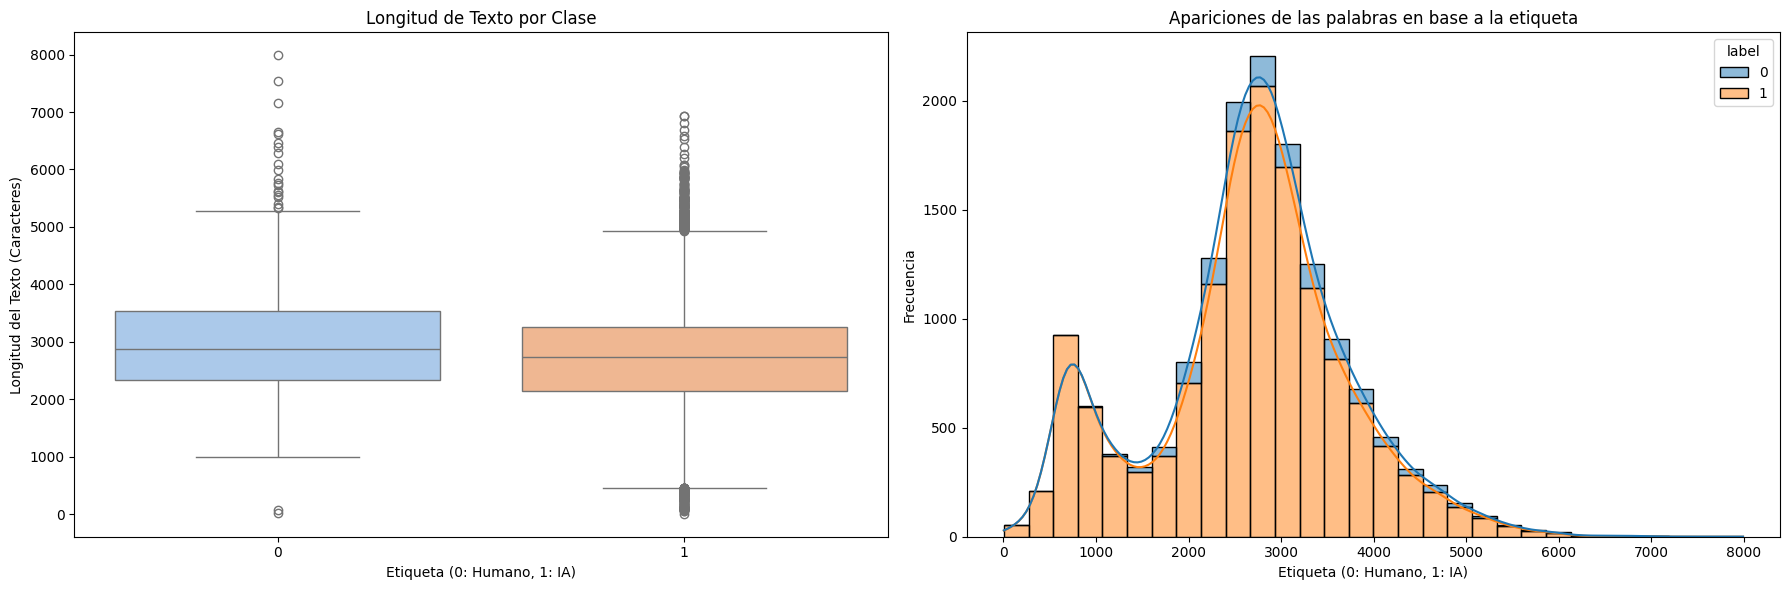

In [38]:
df_machine_temp = df_machine.reset_index(drop=True)
df_machine_temp['label'] = 1

df_temp = pd.concat([df_human_temp, df_machine_temp], axis=0, ignore_index=True)

df_temp["text_length"] = df_temp["text"].apply(len)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# 1. Gráfico de la longitud del texto (Boxplot)
sns.boxplot(data=df_temp, x="label", y="text_length", ax=ax[0], palette='pastel', hue="label", dodge=False, legend=False)
ax[0].set_title("Longitud de Texto por Clase")
ax[0].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[0].set_ylabel("Longitud del Texto (Caracteres)")

# 2. Gráfico de histograma apilado
sns.histplot(data=df_temp, x='text_length', hue='label', multiple='stack', bins=30, kde=True, ax=ax[1])
ax[1].set_title('Apariciones de las palabras en base a la etiqueta')
ax[1].set_xlabel("Etiqueta (0: Humano, 1: IA)")  
ax[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Gracias a estas 2 figuras, podemos apreciar 2 tendencias. La primera es que los humanos tendemos a redactar textos más largos, es decir, damos una información similar pero con una cantidad de carácteres superior. El segundo patrón está relacionada con la redundancia de las palabras, tanto los humanos como los LLMs tendemos a repetir ciertas palabras, lo que podría deberse a la frecuencia de ciertos pronombres, artículos o verbos en un idioma. Más adelante, analizaremos si esta hipótesis es correcta.

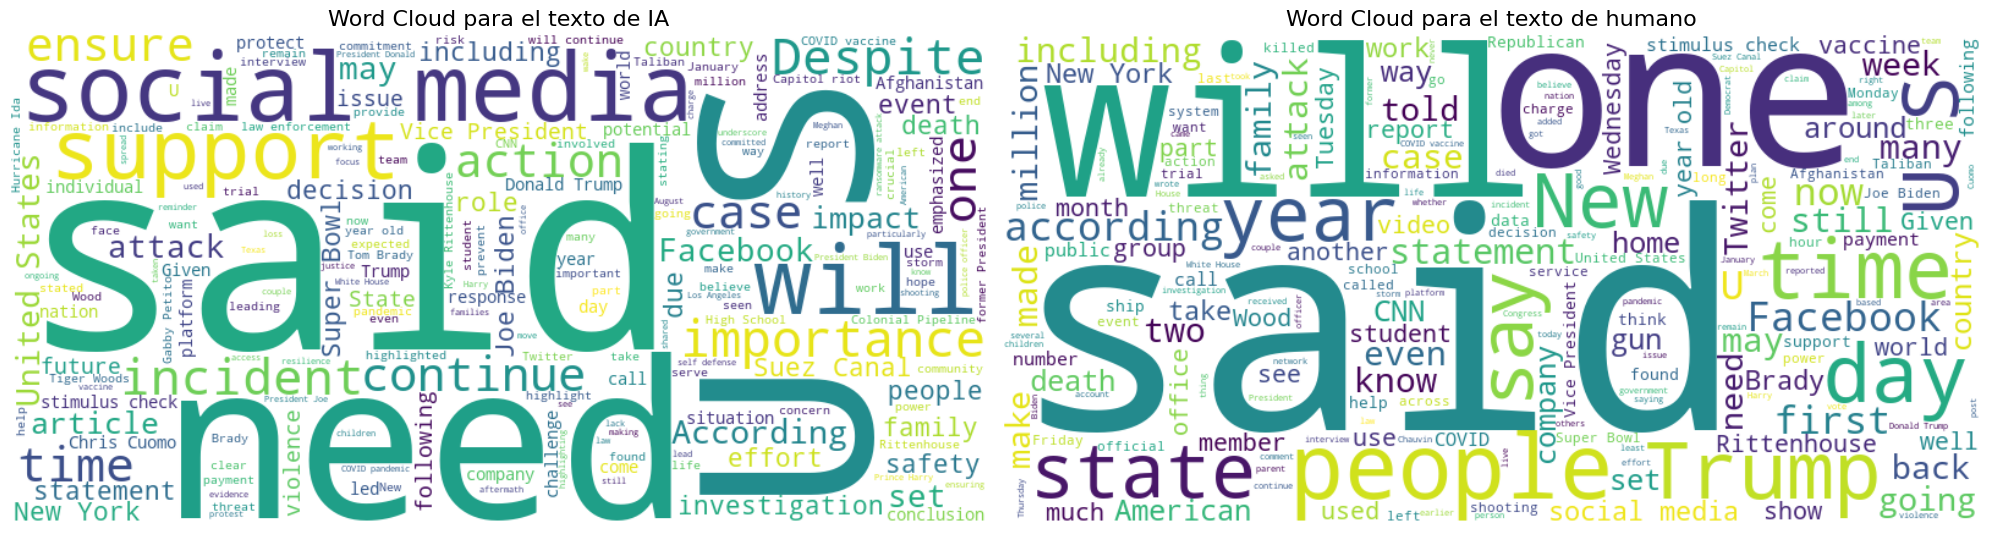

In [50]:
def plot_wordclouds(text1, text2, title1, title2):
    wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(text1)
    wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text2)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    axs[0].imshow(wordcloud1, interpolation='bilinear')
    axs[0].axis('off')  
    axs[0].set_title(title1, fontsize=16)

    axs[1].imshow(wordcloud2, interpolation='bilinear')
    axs[1].axis('off')  
    axs[1].set_title(title2, fontsize=16)
    
    plt.tight_layout()
    plt.show()

text_machine = ' '.join(df_machine['text'].astype(str))
text_humans = ' '.join(df_human['text'].astype(str))

# Generar las nubes de palabras
plot_wordclouds(text_machine, text_humans, title1='Word Cloud para el texto de IA', title2='Word Cloud para el texto de humano')

Parece que hay un conjunto de palabras que es común en ambas situaciones, los humanos y los LLMs comparten palabras importantes como "said", "time", "need", y "people". También podemos apreciar como algunas palabras como "will" tienden a usarse de manera predominante por los humanos. La IA parece usar términos más asociados con reportes o discusiones formales (como "incident", "support" o "according"), mientras que los humanos solemos reflejar un lenguaje más cotidiano o narrativo

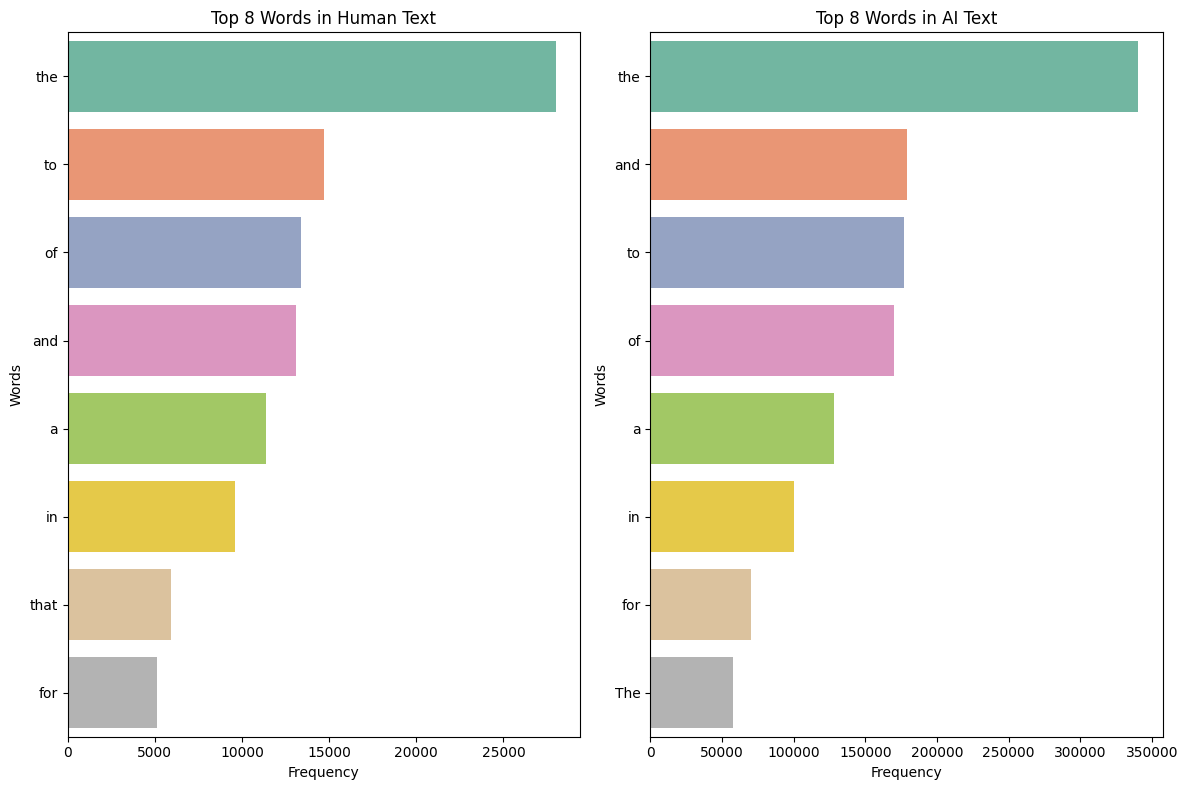

In [40]:
# Función para calcular las frecuencias de palabras
def get_word_frequencies(text):
    words = text.split()
    word_counts = Counter(words)  
    return word_counts

# Asegúrate de usar .loc[] para evitar el SettingWithCopyWarning
df_human.loc[:, 'word_frequencies'] = df_human['text'].apply(get_word_frequencies)
human_frequencies = df_human['word_frequencies'].sum()  # Sumar las frecuencias de todas las filas de texto humano

human_freq_df = pd.DataFrame(human_frequencies.items(), columns=['Word', 'Frequency'])
top_human_words = human_freq_df.nlargest(8, 'Frequency')

# Para las frecuencias de palabras de la máquina (texto de IA)
df_machine.loc[:, 'word_frequencies'] = df_machine['text'].apply(get_word_frequencies)
machine_frequencies = df_machine['word_frequencies'].sum()  # Sumar las frecuencias de todas las filas de texto de IA

machine_freq_df = pd.DataFrame(machine_frequencies.items(), columns=['Word', 'Frequency'])
top_machine_words = machine_freq_df.nlargest(8, 'Frequency')

# Graficar las frecuencias
fig, ax = plt.subplots(1, 2, figsize=(12, 8)) 

sns.barplot(x='Frequency', y='Word', data=top_human_words, ax=ax[0], hue='Word', palette='Set2', legend=False)
ax[0].set_title('Top 8 Words in Human Text')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Words')

sns.barplot(x='Frequency', y='Word', data=top_machine_words, ax=ax[1], hue='Word', palette='Set2', legend=False)
ax[1].set_title('Top 8 Words in AI Text')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Words')

plt.tight_layout()
plt.show()

Como veniamos observando previamente, el uso de preprosiciones y artículos es notable. Con todos estos gráficos presentados a lo largo de la sección de exploración y visualización de datos, ya podemos asegurar que contamos con una gran experiencia en el problema al que nos enfrentamos. Aunque hemos identificado diferencias entre los textos humanos y los generados por IA, la gran cantidad de palabras comunes en el discurso plantea un desafío importante. Estas similitudes, especialmente en las palabras más frecuentes, hacen que la tarea de clasificación sea compleja, ya que los modelos deberán ser capaces de identificar patrones más sutiles y dependientes del contexto para diferenciar entre ambas redacciones.

### Preprocesamiento de los datos

En base a las conclusiones que hemos sacado de la exploración de los datos, iniciamos el preprocesamiento de los mismos. Volvemos a cargar los datos para estudiar la columna `id`, quedandonos con la parte común de los dos dataframes.

In [41]:
df_ids = pd.read_json('data/human.jsonl', lines=True)
df_ids = df_ids[['id']]
df_ids["id"] = df_ids["id"].str.split('/').str[1:].str.join('/')
df_ids

,id
0,news-2021-01-01-2021-12-31-bideninauguration/a...
1,news-2021-01-01-2021-12-31-bideninauguration/a...
2,news-2021-01-01-2021-12-31-bideninauguration/a...
3,news-2021-01-01-2021-12-31-bideninauguration/a...
4,news-2021-01-01-2021-12-31-bideninauguration/a...
...,...
1082,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1083,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1084,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1085,news-2021-01-01-2021-12-31-wyominggabbypetito/...


Cogemos la columna `id` ya que es el nexo de unión entre ambas tablas, y dividimos el conjunto de datos en `TRAIN`, `VALIDATION` y `TEST`.

In [42]:
train_ids_df, temp_df = train_test_split(df_ids, test_size=0.3, random_state=42)
val_ids_df, test_ids_df = train_test_split(temp_df, test_size=1/3, random_state=42)

train_ids_df.shape, val_ids_df.shape, test_ids_df.shape # ≈ 70% / 20% / 10%

((760, 1), (218, 1), (109, 1))

Limpiamos la columna `id` del dataframe de humanos y máquinas en base lo presentado en las celdas anteriores, la tabla resultante es de tamaño igual a $14103$ ya que al hacer el merge buscamos comparar cada frase escrita por un humano con sus respectivas frases escritas por los modelos de IA $(1087 \times 13 = 14131 - 28 \rightarrow 14103)$ .

In [43]:
df_human.loc[:, "id"] = df_human["id"].str.split('/').str[1:].str.join('/')
df_machine.loc[:, "id"] = df_machine["id"].str.split('/').str[1:].str.join('/')

# Combinar los DataFrames
df_combined = pd.merge(df_human, df_machine, on="id", suffixes=("_1", "_2"))

# Añadir las columnas target
df_combined['target_human'] = 1
df_combined['target_machine'] = 0

df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine']]

df_combined

,id,text_1,target_human,text_2,target_machine
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Inaugural Address: President Joseph R. Biden J...,0
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address: A Clarion Call for ...,0
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0
...,...,...,...,...,...
14098,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Long Island Surf Shop Owner Reme...,0
14099,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0
14100,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0
14101,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Super Kind-Heart...,0


A pesar de tener un único dataframe con todo la información importante todavía es pronto para implementar los diferentes `Datasets`. De cara a mejorar la generalización de los futuros LLMs, hemos generado un conjunto de índices que nos ayudarán a "remover" las filas de nuestro dataframe combinado. Además hemos decidido representar la autoría del texto con un tupla en formato `one-hot`. También se realiza una permutación de los textos para que la proporción de `text_1` o `text_2` que es escrito por IA sea similar a la de los textos escritos por humanos. Por consecuencia, se invierte la `target_tuple` para que el entrenamiento sea correcto.

In [44]:
random_indices = df_combined.sample(frac=0.5, random_state=42).index
df_combined.loc[random_indices, ['text_1', 'text_2']] = df_combined.loc[random_indices, ['text_2', 'text_1']].values
df_combined.loc[random_indices, ['target_human']] = 0
df_combined.loc[random_indices, ['target_machine']] = 1
df_combined['target_tuple'] = list(zip(df_combined['target_human'], df_combined['target_machine']))
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine', 'target_tuple']]
df_combined

,id,text_1,target_human,text_2,target_machine,target_tuple
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address: President Joseph R. Biden J...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0,"(1, 0)"
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0,"(1, 0)"
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Biden's Inaugural Address: A Clarion Call for ...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0,"(1, 0)"
...,...,...,...,...,...,...
14098,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito: Long Island Surf Shop Owner Reme...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"
14099,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito: Surf Shop Owner in Hometown Reme...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"
14100,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0,"(1, 0)"
14101,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito Remembered as a 'Super Kind-Heart...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"


1. Borramos las columnas redundantes o inservibles como `id`, `target_human`, `target_machine`. 
2. Recogemos la división anterior y el dataframe combinado para actualizar el conjunto de `TRAIN`, `VALIDATION` y `TEST`.

In [51]:
X_train = df_combined[df_combined['id'].isin(train_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_val = df_combined[df_combined['id'].isin(val_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_test = df_combined[df_combined['id'].isin(test_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])

X_train.shape, X_val.shape, X_test.shape # ≈ 70% / 20% / 10%

((9858, 3), (2831, 3), (1414, 3))

In [46]:
X_train.sample(5)

,text_1,text_2,target_tuple
7221,Crush at Kabul airport kills 7 as Afghans try ...,Chaos and Tragedy at Kabul Airport as Afghans ...,"(1, 0)"
13336,H-E-B scales back operations in winter storm-r...,H-E-B Temporarily Closes Texas Stores Amid Win...,"(1, 0)"
2511,Colonial Pipeline attack: Everything you need ...,Colonial Pipeline Ransomware Attack Highlights...,"(1, 0)"
7030,Taliban Blames U.S. for Kabul Airport Attack; ...,"Taliban Says 'We Can Control Terrorism,' Blame...","(0, 1)"
6711,Louisiana Governor John Bel Edwards on Hurrica...,Louisiana Prepares for Hurricane Ida's Devasta...,"(1, 0)"


Todavía falta un último paso donde actualicemos los `targets`:

In [47]:
y_train = X_train['target_tuple']
y_val = X_val['target_tuple']
y_test = X_test['target_tuple']

X_train = X_train.drop(columns=['target_tuple'])
X_val = X_val.drop(columns=['target_tuple'])
X_test = X_test.drop(columns=['target_tuple'])

y_train.shape, y_val.shape, y_test.shape

((9858,), (2831,), (1414,))

In [48]:
X_train.head(5)

,text_1,text_2
0,Inaugural Address: President Joseph R. Biden J...,Inaugural Address by President Joseph R. Biden...
1,Inaugural Address by President Joseph R. Biden...,What should be the focus of the speech? The In...
2,Inaugural Address by President Joseph R. Biden...,Biden's Inaugural Address Highlights Triumph o...
3,Biden's Inaugural Address: A Clarion Call for ...,Inaugural Address by President Joseph R. Biden...
4,Inaugural Address by President Joseph R. Biden...,"President Biden Emphasizes Unity, Democracy, a..."


In [49]:
y_train.head(5)

0    (0, 1)
1    (1, 0)
2    (1, 0)
3    (0, 1)
4    (1, 0)
Name: target_tuple, dtype: object

### Dataset & DataCollator inicial

Una vez tenemos todos los datos preparados para realizar una primera aproximación al problema, definimos el `Dataset` y el `Collator` teniendo como referencia las diapositivas de la asignatura. Para poder definirlos tenemos que tomar la primera decisión arquitectónica de nuestro `baseline`, viendo las diapositivas, podemos ver que existen dos posibles aproximaciones: *"Head for a single transformer"* o *"A siamese topology"*.

A pesar de que nos gustaría abarcar ambas opciones, de primeras hemos decidido empezar con "Head for a single transformer" ya que parece la más sencilla y así podemos "romper" la barrera de conseguir nuestro primer modelo.

Tomando como referencias las diapositivas:

El dataset simplemente se encarga de representar cada entrada de una manera más sencilla en forma de diccionario. En el cual: 
 - `text_1`: es un texto.
 - `text_2`: es otro texto.
 - `targets`: es el vector one hot que representa si esta escrito por una IA o un humano.

In [52]:
class AiClassificationDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.data = dataframe.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text_1 = self.data.iloc[index]['text_1']
        text_2 = self.data.iloc[index]['text_2']
        target = self.labels.iloc[index]
        return {
            'text_1': text_1,
            'text_2': text_2,
            'targets': target
        }

El Collator se encarga de las operaciones sobre los batches que posteriormente servirán de entrada al modelo.
 - El primer paso es transformar el batch en un diccionario para procesarlo.
 - Después, se introducen los textos en el tokenizer, en este caso el tokenizer es capaz de generar `token_type_ids` lo cual puede ser útil más adelante.
 - Se devuelve un diccionario con los tensores que corresponden a los input_ids, la attention_mask, los token_type_ids y los targets.

In [53]:
class AiClassificationCollator:
    def __init__(self, dataset, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataset
        self.max_len = max_len

    def __call__(self, input_batch):
        batch_dict = {colname: [x[colname] for x in input_batch] for colname in input_batch[0]}

        # Process text_1
        comment_text_1 = batch_dict['text_1']
        comment_text_1 = [" ".join(text.split()) for text in comment_text_1]

        # Process text_2
        comment_text_2 = batch_dict['text_2']
        comment_text_2 = [" ".join(text.split()) for text in comment_text_2]

        inputs = self.tokenizer(
            comment_text_1,
            comment_text_2,
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_token_type_ids=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'targets': torch.tensor(batch_dict['targets'], dtype=torch.float)
        }

## 4. Experimentos

### Estudio del estado del arte

Para seleccionar los modelos que mejor se adapten a esta tarea, hicimos una busqueda inicial del estado de la cuestión para tratar de abarcar lo máximo posible y así tomar decisiones informadas conociendo los principales LLMs disponibles. Existe una variable que va a estar presente a lo largo de todo el proceso, que es la **potencia de computo**.

La capacidad de GPUs a la hora de hacer fine tuning a LLMs es critica. Como veremos más adelante, su disponibilidad va a condicionar tanto los modelos selecionados como la estrategía de los entrenamientos.

Empezamos a revisar la literatura en busca de propuestas más interesantes del campo de estudio, esta busqueda se realizo principalmente a través de **las diapositivas de la asignatura, Hugging Face y la tarea de PAN**, utilizamos **Google Scholar, Web Of Science, Semantic Scholar y Papers With Code** para consultar artículos y los repositorios públicos para resolver algunas dudas conceptuales o de implementación.

Para no extendernos demasido, representaremos en formato tabla los resultados de la busqueda con unas pequeñas conclusiones al final de la misma. Presentando: **Acrónimo, Autores, Año, Origen, Tipo (E-O;D-O;Seq2Seq/E-D), Parámetros (hay muchos modelos publicados con diferentes tamaños, pondremos los que hemos encontrado), Lenguaje y Referencia** de los modelos encontrados:

| **Acrónimo**                     | **Autores**                            | **Origen**   | **Año** | **Tipo**                | **Parámetros**            | **Lenguaje** | **Referencia**                                 |
|---------------------------------|----------------------------------------|----------------|---------|-------------------------|---------------------------|-------------------------|-----------------------------------------------|
| Authorship Unmasking           | Koppel and Schler, Bevendorff et al.   | Comunidad Científica  | 2004, 2019 | NA                        | NA                        | NA                      | [ACM](https://dl.acm.org/doi/abs/10.1145/1015330.1015448), [ACL Anthology](https://aclanthology.org/N19-1068/) |
| PPMd Compression-based Cosine  | Sculley and Brodley, Halvani et al.    | Comunidad Científica  | 2006, 2017 | NA                        | NA                        | NA                      | [IEEE](https://ieeexplore.ieee.org/abstract/document/1607268), [ACM](https://dl.acm.org/doi/abs/10.1145/3098954.3104050) |
| BERT                           | Devlin et al.                          | Google                | 2018       | Encoder-only              | 110M, 340M                | Inglés                  | [BERT: Pre-training of Deep Bidirectional Transformers for Language](https://arxiv.org/abs/1810.04805) |
| DistilBERT                     | Sanh et al.                            | Hugging Face          | 2019       | Encoder-only              | 66M                       | Inglés                  | [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108) |
| GPT-2                          | Radford et al.                         | OpenAI                | 2019       | Decoder-only              | 117M, 345M, 762M, 1.5B    | Inglés                  | [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) |
| RoBERTa                        | Liu et al.                             | Facebook AI           | 2019       | Encoder-only              | 355M                      | Inglés                  | [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692) |
| BART                           | Lewis et al.                           | Facebook AI           | 2019       | Seq2Seq / Encoder-Decoder | 400M                      | Inglés                  | [BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension](https://arxiv.org/abs/1910.13461) |
| ELECTRA                        | Clark et al.                           | Google                | 2020       | Encoder-only              | 14M, 110M, 330M           | Inglés                  | [ELECTRA: Pre-Training Text Encoders as Discriminators Rather than Generators](https://arxiv.org/abs/2003.10555) |
| GPT-3                          | OpenAI                                 | OpenAI                | 2020       | Decoder-only              | 350M, 1.3B, 6.7B, 175B    | Multilingüe             | [GPT-3: Language Models are Few-Shot Learners](https://github.com/openai/gpt-3) |
| T5                             | Raffel et al.                          | Google                | 2020       | Seq2Seq / Encoder-Decoder | 60M                       | Inglés                  | [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683) |
| DEBERTA                        | He et al.                              | Microsoft             | 2021       | Encoder-only              | 110M, 150M, 350M, 1.5B    | Inglés                  | [DEBERTA: Decoding-Enhanced BERT with Disentangled Attention](https://arxiv.org/abs/2006.03654) |
| GPT-J                          | Wang et al.                            | EleutherAI            | 2021       | Decoder-only              | 6B                        | Inglés                  | [GPT-J-6B: A 6 Billion Parameter Autoregressive Language Model](https://huggingface.co/EleutherAI/gpt-j-6b) |
| XML RoBERTa                    | Liu et al., Facebook AI                | Facebook AI           | 2021       | Encoder-only              | 125M - 3.9B               | Multilingüe             | [Unsupervised Cross-lingual Representation Learning at Scale](https://arxiv.org/abs/1911.02116) |
| mGPT                           | Shliazhko et al.                       | Comunidad Científica  | 2022       | Encoder-only              | 1.3B                      | Multilingüe             | [mGPT: Multilingual Language Model for Efficient and Robust Zero-Shot Learning](https://arxiv.org/pdf/2204.07580) |
| BLOOM                          | Scao et al.                            | BigScience            | 2022       | Decoder-only              | 7.1B, 176B                | Multilingüe             | [BLOOM: A 176B-Parameter Open-Access Multilingual Language Model](https://inria.hal.science/hal-03850124/document) |
| OPT-2.7                        | Zhang et al.                           | Meta AI               | 2022       | Decoder-only              | 2.7B                      | Inglés                  | [OPT: Open Pretrained Transformer Models](https://arxiv.org/abs/2205.01068) |
| DeBERTaV3                      | He et al.                              | Microsoft             | 2021       | Encoder-only              | 110M, 350M, 1.5B, 3.9B    | Inglés                  | [DeBERTaV3: Improving DeBERTa using ELECTRA-Style Pre-Training with Gradient-Disentangled Embedding Sharing](https://arxiv.org/abs/2111.09543) |
| GPT NeoX                       | Black et al.                           | EleutherAI            | 2022       | Decoder-only              | 20B, 175B                 | Inglés                  | [GPT-NeoX: An Open-Source Auto-Regressive Language Model](https://doi.org/10.48550/arxiv.2204.06745) |
| GPT-4                          | OpenAI                                 | OpenAI                | 2023       | Decoder-only              | NA                        | Multilingüe             | [GPT-4: OpenAI’s Most Powerful Language Model](https://arxiv.org/abs/2303.08774) |
| Mistral                        | MistralAI                              | MistralAI             | 2023       | Decoder-only              | 7B                        | Multilingüe             | [Mistral: A New Approach for Sparse and Efficient Language Models](https://arxiv.org/pdf/2310.06825) |
| LLaMA                          | Meta AI                                | Meta AI               | 2023       | Decoder-only              | 7B, 13B, 30B, 65B         | Multilingüe             | [LLaMA: Open and Efficient Foundation Language Models](https://arxiv.org/abs/2302.13971) |
| LLaMA2                         | Meta AI                                | Meta AI               | 2023       | Decoder-only              | 7B, 13B, and 70B          | Multilingüe             | [Llama 2: Open Foundation and Fine-Tuned Chat Models](https://openreview.net/pdf?id=UYZJpVEkvq) |
| DetectLLM LRR and NPR          | Su et al.                              | Comunidad Científica  | 2023       | Decoder-only              | ---                       | Inglés                  | [DetectLLM: Leveraging Log Rank Information for Zero-Shot Detection of Machine-Generated Text](https://arxiv.org/abs/2306.05540) |
| DetectGPT                      | Mitchell et al.                        | Comunidad Científica  | 2023       | Decoder-only              | ---                       | Inglés y Alemán         | [DetectGPT: Zero-Shot Machine-Generated Text Detection using Probability Curvature](https://arxiv.org/abs/2301.11305) |
| Fast-DetectGPT                 | Bao et al.                             | Comunidad Científica  | 2023       | Decoder-only              | ---                       | Inglés y Alemán         | [Fast-DetectGPT: Efficient Zero-Shot Detection of Machine-Generated Text via Conditional Probability Curvature](https://arxiv.org/abs/2310.05130) |
| LLaMA3                         | Meta AI                                | Meta AI               | 2024       | Decoder-only              | 8B, 70B, 405B             | Multilingüe             | [LLaMA: Open and Efficient Foundation Language Models](https://arxiv.org/abs/2302.13971) |
| Binoculars                     | Hans et al.                            | Comunidad Científica  | 2024       | Decoder-only              | ---                       | Inglés                  | [Spotting LLMs With Binoculars: Zero-Shot Detection of Machine-Generated Text](https://arxiv.org/abs/2401.12070) |
| Pixtral                        | MistralAI                              | MistralAI             | 2024       | Seq2Seq / Encoder-Decoder | 128B                      | Multilingüe             | [Pixtral: Large Instruct Model](https://huggingface.co/mistralai/Pixtral-Large-Instruct-2411) |

Queda claro que hay un gran número de modelos disponibles, sin embargo hay muchos de ellos que quedan fuera de nuestro alcace debido a su tamaño.

Nuestros recursos principales para el desarrollo de la práctica son una **NVIDIA GeForce RTX 2060 de 6 GB, Google Colab y el uso de la CPU**. Sin embargo, hemos tenido la suerte de poder disponer de **2 NVIDIA L40 de 46 GB** de manera **intermitente** lo que nos ha dado margen para realizar entrenamientos más costosos.

### Baseline: Descripción y primeros resultados

TODO

In [56]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

In [54]:
# @title Customize your key variables here
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512 # @param {type:"integer"}
TRAIN_BATCH_SIZE = 32 # @param {type:"integer"}
VALID_BATCH_SIZE = 32 # @param {type:"integer"}
EPOCHS = 4 # @param {type:"integer"}
LEARNING_RATE = 1e-5 # @param {type:"number"}

In [57]:
training_set = AiClassificationDataset(X_train, y_train)
validation_set = AiClassificationDataset(X_val, y_val)
test_set = AiClassificationDataset(X_test, y_test)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(training_set, tokenizer, MAX_LEN)
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(validation_set, tokenizer, MAX_LEN)
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(test_set, tokenizer, MAX_LEN)
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

In [58]:
for batch in training_loader:
    print("Training Loader Batch:")
    if isinstance(batch, dict):  
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):  
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break  

for batch in validation_loader:
    print("\nValidation Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break

for batch in test_loader:
    print("\nTest Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break


Training Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])

Validation Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])

Test Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])


In [59]:
class TransformerClass(torch.nn.Module):
    def __init__(self):
        super(TransformerClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('google-bert/bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(1024, 256)
        self.l4 = torch.nn.Linear(256, 2)

    def forward(self, ids, mask, token_type_ids):
        last_hidden_state = self.l1(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        ).last_hidden_state

        cls_token = last_hidden_state[:, 0]
        hidden_output = F.gelu(self.l3(self.l2(cls_token)))
        output = self.l4(hidden_output)

        return output

In [27]:
def training_step(input_ids, attention_mask, token_type_ids, y, model, optimizer):
    logits = model(input_ids, attention_mask, token_type_ids)
    optimizer.zero_grad()

    loss = torch.nn.functional.cross_entropy(logits, y, reduction='mean')
    loss.backward()
    
    optimizer.step()

    return loss

In [28]:
model = TransformerClass()
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [29]:
def validate():
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data in validation_loader:
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            logits = model(input_ids, attention_mask, token_type_ids)
            val_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()  # Accumulate validation loss

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_val_loss = val_loss / total_predictions
    accuracy = correct_predictions / total_predictions
    return avg_val_loss, accuracy


In [ ]:
# Ruta del archivo de log
log_file_path = './training_log.txt'

def log_message(message):
    with open(log_file_path, 'a') as log_file:
        log_file.write(message + '\n')
    print(message)

def train(epoch, log_interval=200, save_model_path='./model_weights'):
    global best_accuracy
    model.train()
    running_loss = 0

    for step, data in enumerate(training_loader):
        input_ids = data['ids'].to(device)
        attention_mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        loss = training_step(input_ids, attention_mask, token_type_ids, targets, model, optimizer)
        running_loss += loss.item()

        # Almacenar la pérdida cada cierto número de pasos
        if step % log_interval == 0:
            avg_loss = running_loss / (step + 1)
            log_message(f"Epoch {epoch + 1}/{EPOCHS}, Step {step + 1}/{len(training_loader)}")
            log_message(f"  Running Loss: {avg_loss:.4f}")

    avg_train_loss = running_loss / len(training_loader)

    avg_val_loss, val_accuracy = validate()

    log_message(f"Epoch {epoch + 1}/{EPOCHS} - End of epoch")
    log_message(f"  Training Loss: {avg_train_loss:.4f}")
    log_message(f"  Validation Loss: {avg_val_loss:.4f}")
    log_message(f"  Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        if not os.path.exists(save_model_path):
            os.makedirs(save_model_path)

        model_save_path = os.path.join(save_model_path, f"model_epoch_{epoch + 1}_acc{best_accuracy:.4f}.pth")
        torch.save(model.state_dict(), model_save_path)
        log_message(f"Model saved to {model_save_path}")

best_accuracy = 0

# Al iniciar, limpia el archivo de log si ya existe
if os.path.exists(log_file_path):
    open(log_file_path, 'w').close()

"""Descomentar para entrenar"""
# for epoch in range(EPOCHS):
#        train(epoch)

file_path = f'..\logs\BERT_L_CLS_training_logs.txt'

with open(file_path, 'r') as file:
    content = file.read()

print(content)

FileNotFoundError: [Errno 2] No such file or directory: '..\\logs\\BERT_L_CLS_training_logs.txt'

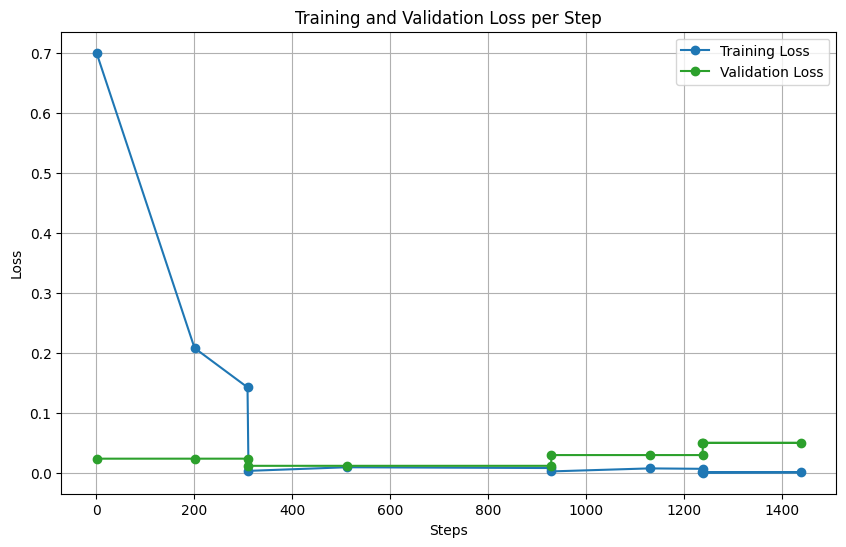

In [ ]:
steps_32 = [1, 201, 309, 310 + 1, 310 + 201, 2 * 309 + 310, 2 * 309 + 310 + 1, 
         2 * 309 + 310 + 201, 3 * 309 + 310, 3 * 309 + 310 + 1, 
         3 * 309 + 310 + 201, 4 * 309]

losses = [
    0.7003, 0.2084, 0.1430, 
    0.0039, 0.0099, 0.0086,
    0.0030, 0.0080, 0.0073,
    0.0008, 0.0015, 0.0018
]

val_losses = [
    0.0242, 0.0242, 0.0242, 
    0.0123, 0.0123, 0.0123,
    0.0302, 0.0302, 0.0302,
    0.0505, 0.0505, 0.0505
]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(steps_32, losses, 'o-', label='Training Loss', color='tab:blue')
plt.plot(steps_32, val_losses, 'o-', label='Validation Loss', color='tab:green')

# Etiquetas y título
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Step')
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

In [ ]:
model = TransformerClass()

model_save_path = f'..\model_weights\BERT_L_CLS\model_epoch_2_acc0.9965.pth'
model.load_state_dict(torch.load(model_save_path, weights_only=False))

model.to(device)

TransformerClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [ ]:
def test(test_loader, model, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0
    total_predictions = 0

    all_targets = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for data in test_loader:
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, token_type_ids)
            test_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()

            # Predicciones y probabilidades
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Acumulamos
            all_probs.extend(probs.cpu().numpy()[:, 1])  # Probabilidades de clase positiva
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.argmax(dim=1).cpu().numpy())  # Para multi-clase, usa el índice

            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_test_loss = test_loss / total_predictions
    accuracy = correct_predictions / total_predictions

    # Métricas adicionales
    roc_auc = roc_auc_score(all_targets, all_probs)
    brier = brier_score_loss(all_targets, all_probs)
    f1 = f1_score(all_targets, all_preds, average='weighted')  # Ajusta el promedio si es necesario
    f05 = precision_recall_fscore_support(all_targets, all_preds, average='weighted', beta=0.5)[2]

    # C@1
    correct = sum(1 for t, p in zip(all_targets, all_preds) if t == p)
    c_at_1 = correct / len(all_preds)

    return avg_test_loss, accuracy, roc_auc, brier, c_at_1, f1, f05


# Ejemplo de uso
test_loss, test_accuracy, roc_auc, brier, c_at_1, f1, f05 = test(test_loader, model, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"C@1: {c_at_1:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F0.5 Score: {f05:.4f}")

Test Loss: 0.0063
Test Accuracy: 0.9972
ROC-AUC: 1.0000
Brier Score: 0.0019
C@1: 0.9972
F1 Score: 0.9972
F0.5 Score: 0.9972


### Propuestas Clasicas

#### Naive Bayes con NLTK

Dejando a un lado los LLMs, plantemos una clasificación alternativa a través de métodos clásicos, usando **NLTK** y **Naive Bayes**. Para ello, vamos a adaptar los datos para probar este nuevo algoritmo. No podemos usar la misma estutructura de datos de `TRAIN` y `TEST` anterior ya que la entrada no van a ser pares de texto.

In [70]:
machines_files = glob('data/machine/*.jsonl')

df_human = pd.read_json('data/human.jsonl', lines=True)

df_human_temp = df_human.reset_index(drop=True)
df_human_temp['label'] = 0

df_machine = pd.read_json(machines_files[0], lines=True)
for file in machines_files[1:]:
    df_current = pd.read_json(file, lines=True)
    df_machine = pd.concat([df_machine, df_current])

df_machine_temp = df_machine.reset_index(drop=True)
df_machine_temp['label'] = 1

df_human_temp = df_human_temp[~df_human_temp['text'].isna() & (df_human_temp['text'] != '')]
df_machine_temp = df_machine_temp[~df_machine_temp['text'].isna() & (df_machine_temp['text'] != '')]

print("Tamaño de df_human_temp:   ", len(df_human_temp))
print("Tamaño de df_machine_temp: ", len(df_machine_temp))

df_temp = pd.concat([df_human_temp, df_machine_temp], axis=0, ignore_index=True)

df_combined = pd.concat([df_human_temp, df_machine_temp], ignore_index=True)
df_combined_nltk = df_combined.drop(columns=['id'])
df_combined_nltk # 14103 + 1087 = 15218 - 28 -> 15190

Tamaño de df_human_temp:    1087
Tamaño de df_machine_temp:  14103


,text,label
0,Inaugural Address by President Joseph R. Biden...,0
1,Fact check: Biden inauguration impacted by pan...,0
2,Highlights from Joe Biden's 2021 inauguration\...,0
3,"Biden takes the helm, appeals for unity to tak...",0
4,'The Hill We Climb': Read Amanda Gorman's inau...,0
...,...,...
15185,'The Disappearance of Gabby Petito' – A Compre...,1
15186,"Utah State Police Search for Gabby Petito, Tra...",1
15187,McKenna's Lost Friend: Debunking the Evidence ...,1
15188,"""Gunshots Found in Florida Nature Preserve: A ...",1


Para optimizar el procesamiento de los datos por parte del algoritmo, vamos a aplicar un filtro al texto. Esta decisión no se tomó anteriormente para evitar sesgar a los modelos, permitiéndoles leer los datos en su formato original y ayudándoles a interiorizar el contenido y detectar patrones por sí mismos.

Para ello vamos a:
1. Convertir a minuscula todas las palabras.
2. Eliminar signos de puntuación.
3. Eliminar las `stopwords` del inglés a través de NLTK, consideramos que no aportan mucho valor semántico a la tarea en cuestión, ya que son demasiado frecuentes y no contribuyen significativamente al análisis.

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df_combined_nltk['text'] = df_combined_nltk['text'].apply(preprocess_text)
df_combined_nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
0,inaugural address president joseph r biden jr ...,0
1,fact check biden inauguration impacted pandemi...,0
2,highlights joe bidens 2021 inauguration washin...,0
3,biden takes helm appeals unity take crises was...,0
4,hill climb read amanda gormans inaugural poem ...,0
...,...,...
15185,disappearance gabby petito – comprehensive ana...,1
15186,utah state police search gabby petito travelin...,1
15187,mckennas lost friend debunking evidence behind...,1
15188,gunshots found florida nature preserve murder ...,1


In [75]:
X = df_combined_nltk['text']
y = df_combined_nltk['label']

X, y

(0        inaugural address president joseph r biden jr ...
 1        fact check biden inauguration impacted pandemi...
 2        highlights joe bidens 2021 inauguration washin...
 3        biden takes helm appeals unity take crises was...
 4        hill climb read amanda gormans inaugural poem ...
                                ...                        
 15185    disappearance gabby petito – comprehensive ana...
 15186    utah state police search gabby petito travelin...
 15187    mckennas lost friend debunking evidence behind...
 15188    gunshots found florida nature preserve murder ...
 15189    kind sweet woman long island shocked remarkabl...
 Name: text, Length: 15190, dtype: object,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 15185    1
 15186    1
 15187    1
 15188    1
 15189    1
 Name: label, Length: 15190, dtype: int64)

Para convertir un conjunto de documentos de texto en una representación numérica existen una gran cantidad de opciones en la literatura. Nosotros hemos selecionado una basada en la frecuencia de términos que viene implementada en `scikit-learn` llamada `TfidfVectorizer`. El calculo de TF-IDF Vectorizer se realiza en 3 partes:

1. **TF (Term Frequency)**: Frecuencia de una palabra en una muestra.
El cálculo de la frecuencia de un término (TF) es el número de veces que una palabra aparece en una muestra, dividido por el número total de palabras en esa muestra.

$$
\text{TF} = \frac{\text{Número de veces que aparece una palabra en la muestra}}{\text{Número total de palabras en la muestra}}
$$

2. **IDF (Inverse Document Frequency)**: Importancia de una palabra inversamente proporcional al número de muestras donde aparece.
El cálculo de IDF refleja la importancia de una palabra, penalizando aquellas que aparecen en muchas muestras, ya que no aportan tanta información. Se calcula como el logaritmo del cociente entre el número total de muestras y el número de muestras donde aparece la palabra.

$$
\text{IDF} = \log \left( \frac{\text{Número total de muestras}}{\text{Número de muestras donde aparece la palabra}} + 1 \right)
$$

3. **TF-IDF**: Producto del TF y el IDF.
El TF-IDF es el producto de la frecuencia del término (TF) y su importancia inversa (IDF). Esto da como resultado una medida ponderada que resalta las palabras más relevantes y únicas en un conjunto de muestras.

$$
\text{TF-IDF} = \text{TF} \times \text{IDF}
$$

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

Generamos un nuevo conjunto de `TRAIN` y `TEST`:

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

X_train, y_train

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 1667095 stored elements and shape (10633, 40470)>,
 11026    1
 565      0
 4118     1
 11051    1
 840      0
         ..
 5191     1
 13418    1
 5390     1
 860      0
 7270     1
 Name: label, Length: 10633, dtype: int64)

Entrenamos a través de `MultinomialNB` con el conjunto de datos creado para `TRAIN`:

In [79]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

Calculamos predicciones con el conjunto de `TEST`:

In [80]:
y_pred = model.predict(X_test)  
y_prob = model.predict_proba(X_test)[:, 1]

Para comprobar la calidad de las predicciones usaremos las misma metricas que para los LLMs. Cabe destacar que no es un comparación formal, este algorimo utiliza un conjunto de `TEST`
diferente y aborda el problema desde otro punto de vista.

In [82]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

f05 = (1 + 0.5**2) * (precision * recall) / ((0.5**2) * precision + recall)

test_loss = brier_score_loss(y_test, y_prob)

roc_auc = roc_auc_score(y_test, y_prob)

def calculate_c_at_1(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    abstained = 0  
    total = len(y_true)
    c_at_1 = (correct_predictions + abstained / 2) / total
    return c_at_1

c_at_1 = calculate_c_at_1(y_test, y_pred)


print(f"Test Loss (Brier Score): {test_loss:.4f}")
print(f"Test Accuracy: {np.mean(y_test == y_pred):.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"C@1: {c_at_1:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F0.5 Score: {f05:.4f}")
print(f"Precision: {precision:.4f}")

Test Loss (Brier Score): 0.0708
Test Accuracy: 0.9289
ROC-AUC: 0.7448
C@1: 0.9289
F1 Score: 0.9631
F0.5 Score: 0.9423
Precision: 0.9289


## 5. Resultados

### Métricas utilizadas

#### 1. Test Accuracy
- **Definition**: The proportion of correctly classified samples out of the total number of samples.
- **Formula**:

$$
  \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Samples}}
$$

- **Interpretation**: Indicates the overall correctness of the model’s predictions. It is a general-purpose metric but may not be ideal for imbalanced datasets.

---

#### 2. ROC-AUC
- **Definition**: The Area Under the Receiver Operating Characteristic Curve (ROC-AUC) measures the model's ability to distinguish between classes. The ROC curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various classification thresholds.
- **Range**: [0, 1]
- **1.0**: Perfect classification.
- **0.5**: Random guessing (no discrimination ability).
- **Interpretation**: Reflects how well the model separates positive and negative classes.

---

#### 3. Brier Score
- **Definition**: Measures the accuracy of probabilistic predictions, quantifying how close predicted probabilities are to actual outcomes.
- **Formula**:

$$
  \text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} (p_i - y_i)^2
$$

Where:
- `p_i`: Predicted probability for the positive class.
- `y_i`: Actual binary label (0 or 1).
- `N`: Total number of samples.
- **Range**: [0, 1]
- **0**: Perfect predictions.
- **1**: Worst predictions (completely wrong probabilities).
- **Interpretation**: A lower score indicates better probabilistic predictions.

---

#### 4. C@1
- **Definition**: A metric that balances accuracy and confidence in predictions. It penalizes unnecessary abstentions or incorrect classifications.
- **Formula**:

$$
  C@1 = \frac{1}{N} \left( c + \frac{u \cdot c}{n} \right)
$$

Where:
- `c`: Number of correct classifications.
- `u`: Number of unanswered instances (abstentions).
- `n`: Total number of classified instances.
- **Interpretation**: Reflects a balance between accuracy and confidence in predictions.

---

#### 5. F1 Score
- **Definition**: The harmonic mean of **precision** and **recall**, balancing the trade-off between the two metrics.
- **Formula**:

$$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Where:
- **Precision**: `True Positives / (True Positives + False Positives)`
- **Recall**: `True Positives / (True Positives + False Negatives)`
- **Range**: [0, 1]
- **1**: Perfect precision and recall.
- **0**: Poor precision and recall.
- **Interpretation**: Indicates how well the model balances precision and recall.

---

#### 6. F0.5 Score
- **Definition**: Similar to F1 Score, but it gives more weight to **precision** than **recall**. This is useful in scenarios where false positives are more critical than false negatives.
- **Formula**:

$$
  F_{0.5} = \left(1 + 0.5^2 \right) \cdot \frac{\text{Precision} \cdot \text{Recall}}{(0.5^2 \cdot \text{Precision}) + \text{Recall}}
$$

- **Range**: [0, 1]
- **1**: Perfect precision and reasonable recall.
- **0**: Poor precision and recall.
- **Interpretation**: Emphasizes the importance of precision over recall.

---

#### Summary Table

| **Metric**      | **Indicates**                                         |
|------------------|-----------------------------------------------------|
| **Test Accuracy**| Overall proportion of correct predictions.          |
| **ROC-AUC**      | Ability to distinguish between positive and negative classes. |
| **Brier Score**  | Accuracy of probabilistic predictions.              |
| **C@1**          | Balance between accuracy and confidence.            |
| **F1 Score**     | Balance between precision and recall.               |
| **F0.5 Score**   | Emphasizes precision over recall.                   |


### Comparativa entre nuestros modelos

| **Model**               | **Test Accuracy** | **ROC-AUC** | **Brier Score** | **C@1** | **F1 Score** | **F0.5 Score** |
|-------------------------|-------------------|-------------|-----------------|---------|--------------|----------------|
| **BERT_base_CLS**       | 0.9958            | 1.0000      | 0.0031          | 0.9958  | 0.9958       | 0.9958         |
| **BERT_base_embedding** |                   |             |                 |         |              |                |
| **BERT_large_CLS**      | 0.9972            | 1.0000      | 0.0019          | 0.9972  | 0.9972       | 0.9972         |
| **BERT_large_embedding**|                   |             |                 |         |              |                |
| **T5Encoder_CLS**       | 0.9936            | 0.9999      | 0.0041          | 0.9936  | 0.9936       | 0.9936         |
| **T5Encoder_embeddings**| 0.9972            | 1.0000      | 0.0023          | 0.9972  | 0.9972       | 0.9972         |
| **Siameses_base**       | 0.9231            | 0.9990      | 0.0572          | 0.9231  | 0.9226       | 0.9274         |
| **Siameses_large**      | 0.9908            | 1.0000      | 0.0207          | 0.9908  | 0.9908       | 0.9909         |


Se puede apreciar en la tabla que los resultados en general son bastante buenos. Aunque habría que destacar algunas relaciones, por ejemplo, los modelos large mejoran al modelo base, pero solo en el caso de las redes siamesas consigue ser una mejora significativa. 

### Comparativa de resultados con los modelos base y otras propuestas publicadas

TODO

## 6. Conclusiones

El Procesamiento del Lenguaje Natural (PLN) es un campo de la inteligencia artificial que avanza con rapidez y es complicado manetener el ritmo del estado del arte. La tarea a realizar en esta práctica consiste en distinguir entre texto escrito por un ser humano y texto generado por una inteligencia artifical como por ejemplo, *llama*, utilizando modelos de transformers preentrenados como BERT y T5. Para esta tarea hemos usado modelos de tipo encoder, ya que destacan en la clasificación de textos porque generan representaciones contextualizadas del texto, aprovechan la autoatención para las dependencias de largo alcance y son muy eficaces en el aprendizaje por transferencia. Su habilidad para ajustarse a diferentes tareas, su habilidad para manejar relaciones complejas entre los tokens y la capacidad de adaptarse a datos particulares de la tarea los hacen la mejor alternativa para la categorización de textos de última generación en el PLN actual.

La eficacia de los modelos de transformers para la clasificación de textos, como BERT y T5, han supuesto un avance significativo en el estado del arte del PLN. Esto se debe a que pueden aprender las representaciones contextuales del texto, lo que los hace especialmente potentes para tareas como la clasificación de textos. Estos modelos captan las dependencias locales y globales del texto, lo que les permite discernir sutiles diferencias entre el texto generado por humanos y el generado por máquinas.

Aunque los modelos están preentrenados, se han entrenado con datos específicos de la tarea, lo cual es esencial para lograr un rendimiento óptimo. En nuestro caso, el ajuste de estos modelos para distinguir entre texto humano y texto generado por IA es crucial para aprovechar todo su potencial.

Un aspecto clave de la tarea es el uso de distintos tipos de representaciones, es decir, tokens CLS frente a la media de los embeddings para alimentar la cabeza clasificadora. El token CLS, a menudo utilizado en modelos como BERT, sirve como resumen de toda la secuencia, que puede utilizarse para tareas de clasificación. Por otro lado, promediar las incrustaciones de los tokens individuales permite al modelo captar potencialmente información más matizada del texto.

La elección de métricas de evaluación como la precisión, el ROC-AUC, la puntuación Brier y la puntuación F1 refleja la importancia no sólo de lograr una alta precisión de clasificación, sino también de evaluar la capacidad del modelo para distinguir entre texto humano y texto de máquina de diversas maneras. Por ejemplo:
 - ROC-AUC evalúa el rendimiento del modelo a través de diferentes umbrales de clasificación, proporcionando información sobre su capacidad para discriminar entre las dos clases.
 - La puntuación $F1$ y la puntuación $F_{0,5}$ destacan el equilibrio entre precisión y recuperación, lo que es importante en situaciones en las que el coste de los falsos positivos o falsos negativos puede variar.
 - La puntuación Brier evalúa la confianza del modelo en sus predicciones, lo que es crucial para tareas en las que la incertidumbre es importante.

La tarea de distinguir entre texto humano y texto generado por máquina es todo un reto, sobre todo a medida que los modelos del lenguaje (por ejemplo, GPT, T5) se vuelven más avanzados. A medida que estos modelos mejoran, generan cada vez más texto que imita la escritura humana con gran fluidez y coherencia. Por tanto, distinguir entre ambos tipos de texto requiere técnicas sofisticadas.

En resumen, esta tarea pone de manifiesto la potencia y flexibilidad de las técnicas modernas de PLN para afrontar retos complejos como la distinción entre texto humano y texto generado por máquinas. Destaca la importancia de perfeccionar los modelos, elegir las representaciones apropiadas y seleccionar las métricas de evaluación adecuadas para este tipo de tareas. A medida que los modelos sigan evolucionando, también lo harán los métodos y estrategias para abordar estos retos de la PNL. También es importante mencionar que el tamaño de estos modelos dificulta mucho su uso mediante el uso de ordenadores domésticos. Y que, en el caso de querer probar más modelos, es necesario usar algún servidor que disponga de gráfica para poder reducir el tiempo empleado en los entrenamientos a algo razonable para una práctica.

## 7. Trabajo futuro

Con respecto al trabajo futuro hay varias posibles líneas para continuar. La primera podría ser probar modelos más actuales y que se encuentren actualmente en el estado del arte, aunque realmente con los modelos que hay en esta práctica ya es complicado mejorar los resultados. Similar a esto se podrían probar diferentes cabezas de clasificación. 

Otra posible linea de trabajo sería hacer promt engineering. Usando librerías como [LangChain](https://www.langchain.com/). Con el uso de esta librería se podría usar un LLM entrenado con propositos generales para realizar una tarea de clasificación a partir de dos textos. Esto sería otra forma de utilizar modelos que son el estado del arte sin la necesidad de entrenarlos, simplemente haciendo uso de ellos a través de prompts. 

Por último, en internet se encuentran múltitud de conjuntos de datos para esta misma tarea, incluso se podrían generar algunos nuevos. Esto podría servir para intentar balancear más los datos y tener mayor variedad de los mismos. Al final la mejor manera de tener un modelo mejor es simplemente hacer uso de más datos. 